In [1]:
import storm_indices as si

import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# Duffy

In [2]:
column_names = ('date', 'ROSarea_comb','ROSn_poly_comb','ROSarea_coastal','ROSn_poly_coastal','ROSarea_oceanic','ROSn_poly_oceanic')

polynyas = pd.read_csv('../Data/duffy/results/results/polynya_daily_summary_0p5.csv')
polynyas['date'] = pd.to_datetime(polynyas['date'], format='%Y-%m-%d')
polynyas = polynyas.set_index('date')
polynyas = polynyas.resample('MS').mean()
polynyas['duffy'] = polynyas['ROSarea_comb']
polynyas = polynyas[['duffy']]

polynyas

,duffy
date,
1979-01-01,14002.198933
1979-02-01,2812.948655
1979-03-01,2617.201360
1979-04-01,4791.511708
1979-05-01,2239.772341
...,...
2022-08-01,685.485204
2022-09-01,1187.412999
2022-10-01,6970.505446


# SAM
#### from https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/aao/aao.shtml

In [3]:
SAM = pd.read_csv('../Data/atmospheric_modes/SAM_ncep.txt', names=['year', 'month', 'sam'], sep='\s+')
SAM['date'] = pd.to_datetime(dict(year=SAM['year'], month=SAM['month'], day=1))
SAM = SAM.set_index('date')[['sam']]
#SAM = SAM.loc['1979-01-01':'2022-12-01']    # Set to same time frame as Duffy's polynya dataset.
SAM

,sam
date,
1979-01-01,0.2088
1979-02-01,0.3563
1979-03-01,0.8992
1979-04-01,0.6776
1979-05-01,0.7237
...,...
2025-01-01,-0.0803
2025-02-01,-0.2708
2025-03-01,0.7332


# Storm Index

In [4]:
station_name = 'ScottBase'
t_column_name = 'Mean Temperature [Deg C]'
p_column_name = 'Mean sea level pressure [Hpa]'
TP = pd.read_csv('../Data/scottbase/scottbase.csv')
TP['date'] = pd.to_datetime(TP['DateTime'],format='%Y-%m-%d')
TP.index = TP['date']
del TP['date']
TP = TP[[t_column_name, p_column_name]]
TP = TP[~TP.index.isna()]
SI = si.compute_si(TP, t_column_name, p_column_name, 'si')
SI = SI.resample('MS').mean()
SI = SI[['si']]
#SI = SI.loc['1979-01-01':'2022-12-01']    # Set to same time frame as Duffy's polynya dataset.

SI

,si
date,
1964-09-01,0.000000
1964-10-01,0.196919
1964-11-01,0.015684
1964-12-01,0.109812
1965-01-01,0.076387
...,...
2025-01-01,0.046163
2025-02-01,0.249860
2025-03-01,0.371334


# Combine

In [5]:
df = SI.join(SAM, how='outer')
df = df.join(polynyas, how='outer')
# Normalize
df = (df - df.mean()) / df.std()
df

,si,sam,duffy
date,,,
1964-09-01,-0.772661,NaN,NaN
1964-10-01,-0.408848,NaN,NaN
1964-11-01,-0.743684,NaN,NaN
1964-12-01,-0.569781,NaN,NaN
1965-01-01,-0.631533,NaN,NaN
...,...,...,...
2025-01-01,-0.687374,-0.193250,NaN
2025-02-01,-0.311037,-0.387744,NaN
2025-03-01,-0.086610,0.637303,NaN


# Plot

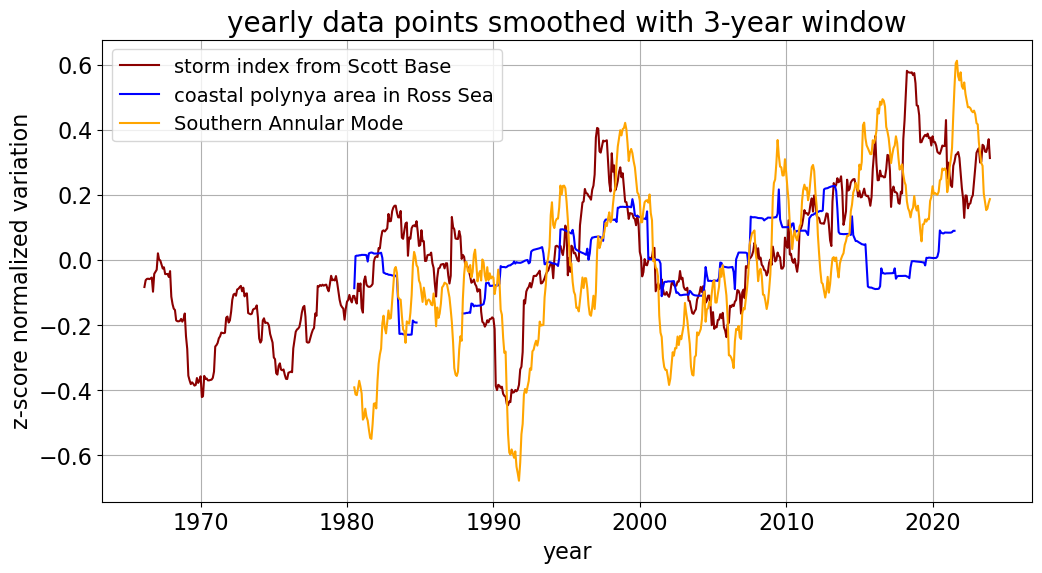

In [6]:
window_width = 3 * 12

fig, ax = plt.subplots(1, 1, figsize=(12,6))

ax.plot(df.index, df['si'].rolling(window=window_width, center=True).mean(), label='storm index from Scott Base', color='darkred')
ax.plot(df.index, df['duffy'].rolling(window=window_width, center=True).mean(), label='coastal polynya area in Ross Sea', color='blue')
ax.plot(df.index, df['sam'].rolling(window=window_width, center=True).mean(), label='Southern Annular Mode', color='orange')

ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel('year', fontsize=16)
ax.set_ylabel('z-score normalized variation', fontsize=16)
ax.set_title('yearly data points smoothed with '+str(int(window_width/12))+'-year window', fontsize=20)
ax.legend(fontsize=14)

plt.savefig('../Figures/RossSea_polynyas_and_'+str(station_name)+'_SI_'+str(int(window_width/12))+'_year_smoothing_window_new', bbox_inches='tight')
plt.show()

### Butterworth Filter

In [7]:
window_width = 7

In [8]:
fs = 12  # samples per year
cutoff = 1/window_width  # (window_width)-year period
wn = cutoff / (0.5 * fs)
b, a = butter(N=4, Wn=wn, btype='low')

filtered = {}

for col in ['duffy', 'si', 'sam']:
    series = df[col].dropna()
    y = filtfilt(b, a, series)
    filtered[col] = pd.Series(y, index=series.index)

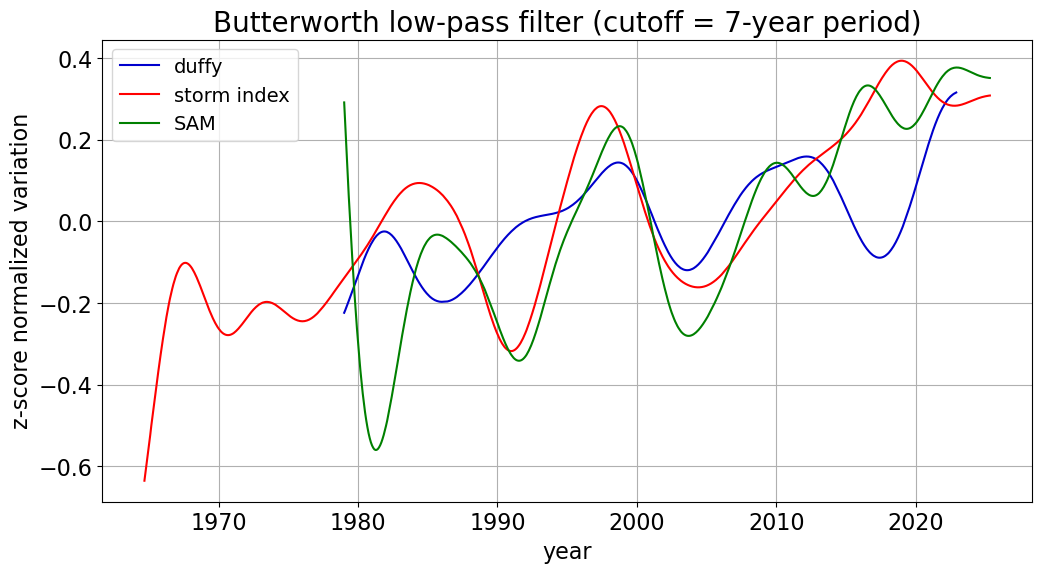

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.plot(filtered['duffy'], label='duffy', color='mediumblue')
ax.plot(filtered['si'], label='storm index', color='red')
ax.plot(filtered['sam'], label='SAM', color='green')

ax.tick_params(labelsize=16)
ax.grid()
ax.set_xlabel('year', fontsize=16)
ax.set_ylabel('z-score normalized variation', fontsize=16)
ax.set_title('Butterworth low-pass filter (cutoff = '+str(window_width)+'-year period)', fontsize=20)
ax.legend(fontsize=14)

plt.savefig('../Figures/RossSea_polynyas_SAM_and_'+str(station_name)+'_SI_'+str(window_width)+'_year_Butterworth', bbox_inches='tight')
plt.show()